# Data validation
The main idea of this notebook is to validate that the processed dataset is ready for training. To do that first the data will be checked in order to ensure that it can be loaded correctly and the transformations done in preprocessing are correct. Afterwards, the analysis will be focused on batch creation and data transformation/augmentation techniques that could be applied to this data in order to achieve the best results. The general schema will be the following:

* 1. Data loading and verification
* 2. Batch creation
* 3. Data transformation/augmentation
* 4. Conclusion

First it is required to load the necessary libraries:

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import yaml
from tqdm import tqdm
from collections import defaultdict
import altair as alt

import torch
from torch.utils.data import DataLoader, WeightedRandomSampler
import albumentations as A
from torchvision import transforms
import cv2
from albumentations.pytorch import ToTensorV2
import torchvision.datasets as datasets

# Set seeds
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# To add src to the path so that we can import modules
current_directory = os.getcwd()
if not current_directory.endswith("emotion_recognition"):
    sys.path.append(os.path.join(current_directory, 'emotion_recognition'))

try:
    from src import ROOT_DIR, PROCESSED_AFFECTNET_DIR, NUMBER_OF_EMOT, AFFECTNET_CAT_EMOT
    from src.visualization.visualize import  visualize_batch, compute_cat_label_batch_entropy
    from src.data.dataset import AffectNetDatasetValidation
except ModuleNotFoundError:
    print("Ensure that src is added to PATH and restart the kernel")
    print(sys.path)

# 1. Data loading and verification
In this section, the analysis will be focused on ensuring that the data is consistent and if there are any missing values. Furthermore, the transformations done in the preprocessing step will be checked. First, the flags used in the preprocessing step are shown.

In [2]:
# Path of the parameters file
params_path = os.path.join(ROOT_DIR,"params.yaml")

# Read data preparation parameters
with open(params_path, "r", encoding='utf-8') as params_file:
    try:
        params = yaml.safe_load(params_file)
        params = params["preprocessing"]
    except yaml.YAMLError as exc:
        print(exc)
params_df = pd.DataFrame.from_dict(params, orient='index', columns=['Value'])
params_df.index.name = 'Parameter'
print(params_df)


                         Value
Parameter                     
random_seed                 33
orig_datasets      [affectnet]
train_split                0.8
continuous_format    cartesian


And these are the contents of the processed directory. There are three datasplits that are going to be used for training, validation and testing.

In [3]:
print ("AffectNet processed data directory: ", PROCESSED_AFFECTNET_DIR)
datasplits = ['train', 'val', 'test']
files_by_datasplit = {datasplit: [] for datasplit in datasplits}
all_files = os.listdir(PROCESSED_AFFECTNET_DIR)

for item in all_files:
    for datasplit in datasplits:
        if datasplit in item.split(".")[0].split("_"):
            files_by_datasplit[datasplit].append(item)

for datasplit, files in files_by_datasplit.items():
    print(f"{datasplit}:")
    for file in files:
        print(f"\t{file}")
        if file in all_files:
            all_files.remove(file)        

print("Other files:")
for file in all_files:
    print(f"\t{file}")


AffectNet processed data directory:  C:\Users\arman\Desktop\emotion_recognition\data\affectnet\processed
train:
	data_weights_train.pt
	label_weights_train.pt
	train_cat_emot.dat
	train_cont_emot.dat
val:
	label_weights_val.pt
	val_cat_emot.dat
	val_cont_emot.dat
test:
	data_weights_test.pt
	label_weights_test.pt
	test_cat_emot.dat
	test_cont_emot.dat
	test_imgs.dat
Other files:
	dataset_normalization_values.pt
	datasplit_sizes.csv


The result shows that for each datasplit there are 4 files: the images, the categorical and continuous labels and the data weights. The id is implicit in the order of the numpy arrays. There are two remaining files that show the datasplit sizes and the mean and standard deviation of the images using the training and validation data splits. First, the datasplit sizes are shown:

In [4]:
datasplit_sizes_df = pd.read_csv(os.path.join(PROCESSED_AFFECTNET_DIR,"datasplit_sizes.csv"))
print(datasplit_sizes_df)
print(f"There is a total of {datasplit_sizes_df['Size'].sum()} entries in the AffectNet dataset")
train = datasplit_sizes_df[datasplit_sizes_df['Datasplit'] == 'train']['Size'].values[0]
val = datasplit_sizes_df[datasplit_sizes_df['Datasplit'] == 'val']['Size'].values[0]
print(f"The split relation for train with respect original training dataset is {train/(train+val):.3f}, the expected is {params['train_split']}")

  Datasplit    Size
0     train  230120
1       val   57531
2      test    3999
There is a total of 291650 entries in the AffectNet dataset
The split relation for train with respect original training dataset is 0.800, the expected is 0.8


The values are inside the expected results. The next step is to load the data and check if the transformations are correct. As the imgs are stored as unsigned ints, if they can be loaded correctly they will be inside the range [0, 255]. The categorical labels are expected to be in [0,7] interval and the continuous labels are expected to be in [-1,1] interval inside the unit circle. So the following condition must be fulfilled for the continuous labels:
$$\sqrt{c_1^2+c_2^2}\leq 1$$

In [5]:
for datasplit in datasplits:
    print(f"Checking {datasplit} data loading")
    datasplit_path = os.path.join(PROCESSED_AFFECTNET_DIR, datasplit)
    datasplit_len = datasplit_sizes_df[datasplit_sizes_df['Datasplit'] == datasplit]['Size'].values[0]
    store_imgs = np.memmap(datasplit_path+"_imgs.dat", dtype=np.uint8, 
                                mode='r', shape=(datasplit_len, 224, 224, 3))
    store_cat_emot = np.memmap(datasplit_path+"_cat_emot.dat", dtype=np.int64, 
                                mode='r', shape=datasplit_len)
    store_cont_emot = np.memmap(datasplit_path+"_cont_emot.dat", dtype=np.float32, 
                                mode='r', shape=(datasplit_len, 2))
                                
    store_cat_emot=torch.from_numpy(store_cat_emot)
    valid_emot = torch.tensor(range(NUMBER_OF_EMOT))
    is_in_range = store_cat_emot.view(1, -1).eq(valid_emot.view(-1, 1)).sum(0)
    if torch.any(is_in_range == 0).item():
        print(f"\tThere are some values of cat_emot outside the range")
    else:
        print("\tAll values of cat_emot are inside the range")

    store_cont_emot = torch.from_numpy(store_cont_emot)
    is_outside_range = torch.any(torch.logical_or(store_cont_emot < -1.0, store_cont_emot > 1.0))
    if torch.any(is_outside_range == 1).item():
        print(f"\tThere are some values of cont_emot outside the range")
    else:
        print("\tAll values of cont_emot are inside the range")
    distances_from_origin = torch.sqrt(store_cont_emot[:, 0]**2 + store_cont_emot[:, 1]**2)
    inside_unit_circle = torch.any(distances_from_origin <= 1)
    if inside_unit_circle.item():
        print("\tAll values of cont_emot are inside the unit circle")
    else:
        print(f"\tThere are some values of cont_emot outside unit circle")
            
    print(f"\tData loading successful for {datasplit}")
        
    print("\nData loading successful")

Checking train data loading


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\arman\\Desktop\\emotion_recognition\\data\\affectnet\\processed\\train_imgs.dat'

All values are consistent with the preprocessing and there are no missing values. So the analysis can proceed with the batch creation and data augmentation. 

# 2. Batch creation
The main idea of this section is to check if the dataloader works correctly and study if using a weighted batch sampler can solve the issue of data imbalance. For this section, the categorical label will be studied, as for continuous labels the implementation of the same idea is harder. The analysis will be divided in the following two steps:
* 2.1. Dataloader creation and verification 
* 2.2. Weighted batch sampler

## 2.1 Dataloader creation and verification

To start the verification, a batch of data is created to later on check if the dataloader works correctly. A subset of size `batch_size * bacthes` will be used for this purpose.

In [ ]:
batch_size = 32
batches = 100
selected_rows = range(batch_size*batches)

Now the data is loaded using the dataloaders:

In [ ]:
# Create the datasets
dataset_train = AffectNetDatasetValidation(path = PROCESSED_AFFECTNET_DIR, datasplit = "train", img_transforms = A.Compose([ToTensorV2()]))
dataset_val = AffectNetDatasetValidation(path = PROCESSED_AFFECTNET_DIR, datasplit = "val", img_transforms = A.Compose([ToTensorV2()]))
dataset_test = AffectNetDatasetValidation(path = PROCESSED_AFFECTNET_DIR, datasplit = "test", img_transforms = A.Compose([ToTensorV2()]))
# Take a subset of the datasets
dataset_train = torch.utils.data.Subset(dataset_train, selected_rows)
dataset_val = torch.utils.data.Subset(dataset_val, selected_rows)
dataset_test = torch.utils.data.Subset(dataset_test, selected_rows)
# Create the dataloaders
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=False)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

Now the first batch of data is plotted to see if the dataloader works correctly (for training split):

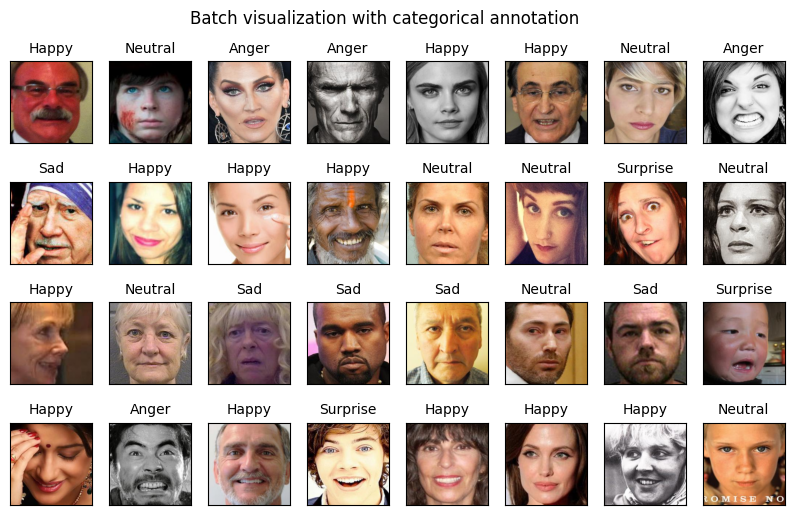

In [ ]:
dataiter = iter(dataloader_train)
img, cat_label, cont_label, _ = next(dataiter)
visualize_batch(img, cat_label)

Dataloaders work correctly and images are ready to be trained. Now the focus will be on the data imbalance issue. First, the distribution of the labels in the training set will be checked and the objective will be to create a weighted batch sampler to solve the issue. The dataloader structure will be the same one. 

## 2.2 Weighted batch sampler
As seen in AffectNet data exploration, there is a heavy bias towards positive emotions, concretly to happy and neutral emotions. In this section, the focus will be centered on creating a weighted batch sampler to solve this issue. The categorical label will be studied, as for continuous labels the implementation of the same idea is harder.

To get a sense on how the emotions are distributed in each batch the masure used will be entropy. Entropy is the measure of suprise or uncertainty of the variables possible outcomes. So it is a good measure to see how uncertain the categorical labels in a batch will be (the idea is to maximize it). This is the mathematical definition:

$$H(X):=-\sum_{x\in \mathcal{X}} p(x)· log(p(x))$$

**Note:** The choice of base for the logarithm, varies for different applications. For this case, the base usen will be $e$, so it is in "natural units" nat.

The lower bound of entropy is a deterministic event, where in a batch we have only one emotion (in this case the entropy is 0).
$$H(D)=- 1 · log(1)=-log(1) = 0$$

The objective is that all batches labels are as uncertain as possible. So the sampler will have to seek the uniform distribution of categorical labels in each batch, so that will be the upper bound of this measure. In case of a uniform distribution of 8 possible outcomes or emotions the entropy value is the following: 
$$H(U)=-\sum_{i=1}^{8}  1/8 · log(p(i))=-log(1/8) \approx 2.079$$

After this theory introduction and problem definition, the entropy of the labels across the batches for all data splits is plotted:

In [ ]:
bar_plot_train = compute_cat_label_batch_entropy(dataloader_train, NUMBER_OF_EMOT, title = "Train")
bar_plot_val = compute_cat_label_batch_entropy(dataloader_val, NUMBER_OF_EMOT, title = "Validation")
bar_plot_test = compute_cat_label_batch_entropy(dataloader_test, NUMBER_OF_EMOT, title = "Test")
alt.hconcat(bar_plot_train, bar_plot_val, bar_plot_test).properties(
    title = alt.Title("Entropy of batches regarding the categorical labels in the datasets", anchor = "middle", fontSize = 20))

100%|██████████| 100/100 [00:00<00:00, 159.34it/s]


alt.HConcatChart(...)

It can be observed that `train` and `validation` splits have a similar entropy and it is far from the upper bound, as these splits have unbalanced labels. Some emotions are more common so there is "less suprise" when they appear in the batch. This means that if we forward these batches to the model, it will have a bias to predict the most common emotions. 

This is not the case for the `test` split, as it has a higher entropy closer to the upper bound that represents the uniform distribution. This is due to the fact that the test split by nature was created to be as close as possible to the uniform distribution of the labels. There is few variability in the entropy across the batches as the sampling from this uniform dataset is random (so this uniformity may change). 

The idea is to create a weighted dataloader, so that the model sees the same amount of each emotion in each batch. This is important because the model will learn to predict the most common emotion if the distribution of emotions is not uniform. To start implementing the weighted data loader, it is needed to load the data weights generated from data preprocessing:

In [ ]:
train_weights = torch.load(os.path.join(PROCESSED_AFFECTNET_DIR, "data_weights_train.pt"))
print(f"Train weights: {train_weights}")

Train weights: tensor([9.2809e-06, 1.6717e-05, 5.0153e-05,  ..., 4.9500e-05, 4.9500e-05,
        9.2809e-06])


Afterwards, the weighted random sampler is created. The weight for each class is the reciprocal of the total times it appear on the dataset (already computed in preprocessing). This will ensure that classes with a higher representation will have a smaller weight. The data used for this purpose is the same one as before:

In [ ]:
reduced_train_weights = torch.empty(len(dataset_train))
it = 0 # Index of the reduced_train_weights
for idx in dataset_train.indices:
    reduced_train_weights[it] = train_weights[idx]
    it += 1

Now the dataloader is created using these weights for the small subset. 

In [ ]:
sampler = WeightedRandomSampler(reduced_train_weights, len(dataset_train), replacement=True)
dataloader_train_weighted = DataLoader(dataset_train, batch_size=batch_size, shuffle=False, sampler=sampler)

Looking at the torch weighted random sampler function, the ``replacement`` variable is set as true in order to oversample the smaller categories and as a result undersample the majority classes. For now, the number of samples per epoch is set as the length of the dataset, but this could be changed. 

The results are following, showing the entropy of the labels across the batches for the training data split with/out the weighted random sampler:

In [ ]:
selected_rows = range(min(batch_size*batches, len(dataset_train)))
bar_plot_train = compute_cat_label_batch_entropy(dataloader_train, NUMBER_OF_EMOT, title = "Train without weighting")
bar_plot_train_weighted = compute_cat_label_batch_entropy(dataloader_train_weighted, NUMBER_OF_EMOT, title = "Train weighted")
alt.hconcat(bar_plot_train, bar_plot_train_weighted).properties(
    title = alt.Title("Entropy of batches with/out weighted sampling", anchor = "middle", fontSize = 20))

 21%|██        | 21/100 [00:00<00:00, 198.50it/s]

100%|██████████| 100/100 [00:00<00:00, 212.57it/s]


alt.HConcatChart(...)

Looking at the chart, there is an overall improvement in the entropy of the labels across the batches. The entropy is closer to the upper bound, so the model will see a more uniform distribution of emotions in each batch. It is expected that this will help the model to learn to predict all emotions equally. The weighted random sampler is working correctly and at first glance it is effective solving the data imbalance issue.

But as mentioned earlier, the function oversamples small categories. Now the analysis will focus on how often a certain image with a certain emotion is seen, in order to get an oversampling or undersampling notion. A small subset of the data is taken for this purpose and the evolution after 20 epochs will be shown. 

In [ ]:
total_images = batch_size * batches
sampler = WeightedRandomSampler(reduced_train_weights, len(dataset_train), replacement=True)
dataloader_train_weighted = DataLoader(dataset_train, batch_size=batch_size, sampler=sampler, drop_last=True)

In [ ]:
total_epochs = 20
image_counts = defaultdict(lambda:0) # Initialize the image_counts dictionary
image_emotion = defaultdict(lambda:0) # Initialize the image_emotion dictionary
distinct_images_seen = []
emotions_reseen = []
for epoch in range (total_epochs):
    for i, (_, cat_emot, _, ids) in enumerate(dataloader_train_weighted):
        emot = cat_emot.numpy()
        it = 0
        for id in ids.numpy():
            # Increment the count for id in image_counts
            image_counts[id] += 1
            if id not in image_emotion:
                image_emotion[id] = emot[it]  
            it += 1
    # Update the distinct_images_seen for the epoch
    distinct_images_seen.append({'Epoch': epoch+1, 'Seen dataset': len(image_counts)/total_images}) 
    print(f"Epoch {epoch+1} - Seen dataset: {len(image_counts)/total_images}")

    # Update the emotions_reseen for the epoch
    emotions_counts = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[]}
    for id in dataset_train.indices:
        # Append the emotion to the list of the corresponding emotion, if not found append 0
        emotions_counts[image_emotion[id]].append(image_counts.get(id,0)) 
        
    for emotion in range(NUMBER_OF_EMOT):
        average = sum(emotions_counts[emotion])/len(emotions_counts[emotion])
        emotions_reseen.append({'Epoch': epoch + 1, 'Emotion': emotion, 'Average seen': average})

    # Check if all the images have been seen
    if distinct_images_seen[epoch]['Seen dataset'] == 1.0:
        break

Epoch 1 - Seen dataset: 0.4403125
Epoch 2 - Seen dataset: 0.6146875
Epoch 3 - Seen dataset: 0.724375
Epoch 4 - Seen dataset: 0.7990625
Epoch 5 - Seen dataset: 0.850625
Epoch 6 - Seen dataset: 0.888125
Epoch 7 - Seen dataset: 0.919375
Epoch 8 - Seen dataset: 0.941875
Epoch 9 - Seen dataset: 0.958125
Epoch 10 - Seen dataset: 0.9678125
Epoch 11 - Seen dataset: 0.9740625
Epoch 12 - Seen dataset: 0.98125
Epoch 13 - Seen dataset: 0.9853125
Epoch 14 - Seen dataset: 0.9896875
Epoch 15 - Seen dataset: 0.9928125
Epoch 16 - Seen dataset: 0.9946875
Epoch 17 - Seen dataset: 0.9959375
Epoch 18 - Seen dataset: 0.9971875
Epoch 19 - Seen dataset: 0.9975
Epoch 20 - Seen dataset: 0.9984375


The results are the following the focus will be first on the evolution of how many times an image is seen per emotion:

In [ ]:
emotions_reseen_df = pd.DataFrame(emotions_reseen)
cat_emot_dict = {id:AFFECTNET_CAT_EMOT[id] for id in range(NUMBER_OF_EMOT)}
emotions_reseen_df['Emotion'] = emotions_reseen_df['Emotion'].map(cat_emot_dict)

In [ ]:
line_plot = alt.Chart(emotions_reseen_df).mark_line().encode(
    x=alt.X('Epoch:O', title='Epoch', axis=alt.Axis(labelAngle=0)),
    y='Average seen',
    color=alt.Color('Emotion:N', legend=alt.Legend(title='Emotion', labelColor='black', titleColor='black')),
).properties(
    title='Average same photo seen w.r.t an emotion over epochs',
    width=400,
    height=300
)

line_plot += alt.Chart(emotions_reseen_df).mark_point(size=50, filled=True).encode(
    x=alt.X('Epoch:O', title='Epoch'),
    y='Average seen:Q',
    color=alt.Color('Emotion:N', legend=alt.Legend(title='Emotion', labelColor='black', titleColor='black')),
    tooltip=[
        alt.Tooltip('Emotion', title='Emotion'),    
        alt.Tooltip('Epoch', title='Epoch'),
        alt.Tooltip('Average seen', title='Average seen', format='.2f'),
    ]
)

line_plot.interactive()


alt.LayerChart(...)

As expected, the growth in all emotions is linear, and the growth is inversely proportional to how many times the emotion is seen in the dataset. This is the expected behavior of the weighted random sampler. Emotions as `Contempt` and `Disgust` are much more oversampled with almost 200 visualizations per photo after 20 epochs. In the other side, `Happy` and `Neutral` are seen less often, with only 6-8 times per photo after the epochs.

Now the oversampling and undersmapling factor for each emotion is computed:

In [ ]:
last_epoch = emotions_reseen_df.loc[emotions_reseen_df['Epoch'] == 20, ['Emotion', 'Average seen']].reset_index(drop=True)
last_epoch['Average seen'] = last_epoch['Average seen'] / 20

In [ ]:
sampling_factor = alt.Chart(last_epoch).mark_point(size=200, filled=True).encode(
    x=alt.X('Emotion:O', title='Emotion', sort='y', axis = alt.Axis(labelAngle=0)),
    y=alt.Y('Average seen:Q', title='Average seen per epoch (log-scale)', scale=alt.Scale(type='log', base=10, domain=[0.1, 10])),
    tooltip=[
        alt.Tooltip('Emotion', title='Emotion'),    
        alt.Tooltip('Average seen', title='Average seen per epoch', format='.2f'),
    ]
).properties(
    title=alt.Title("Sampling factor of emotions", anchor="middle", fontSize=20),
    width=400,
    height=300
)
line = alt.Chart(pd.DataFrame({'y': [1]})).mark_rule(color='black', strokeWidth=2).encode(y='y:Q')
sampling_factor_with_line = alt.layer(sampling_factor, line)

sampling_factor_with_line = sampling_factor_with_line + alt.Chart(pd.DataFrame({'text': ['Sampling Factor 1']})).mark_text(
    align='left',
    baseline='middle',
    dx=5,
    dy=-5,
    fontSize=12,
    fontWeight='bold'
).encode(
    x=alt.value(0),
    y=alt.value(143),
    text='text'
)

sampling_factor_with_line.interactive()

alt.LayerChart(...)

And here it can be observed the notion of oversampling and undersampling. The log-scale is used in the ``Average seen per epoch`` axis in order to get a better sense when comparing the ratios. The value is basically the step of the line in the previous chart. Almost all categories are oversampled. And only `Happy` and `Neutral` are undersampled. This is the expected behavior of the weighted random sampler. As each photo of less common emotions is seen more often, it is required good augmentation techniques to avoid overfitting.

Now the study will focus on the dataset sampler. As the sampler has replacement, it is possible that some images are not seen unless many epochs has been done.

In [ ]:
distinct_images_seen_df = pd.DataFrame.from_dict(distinct_images_seen)
line_plot = alt.Chart(distinct_images_seen_df).mark_line().encode(
    x=alt.X('Epoch', title='Epoch', scale = alt.Scale(domain = (1, 20))),
    y=alt.Y('Seen dataset:Q', title='Acumulative seen dataset'),
    tooltip=[
        alt.Tooltip('Epoch', title='Epoch'),
        alt.Tooltip('Seen dataset', title='Acumulative seen dataset', format='.2%')
    ]
).properties(
    height=300,
    width=600,
)

line_plot += alt.Chart(distinct_images_seen_df).mark_point().encode(
    x=alt.X('Epoch', title='Epoch', scale = alt.Scale(domain = (1, 20))),
    y='Seen dataset:Q',
    tooltip=[
        alt.Tooltip('Epoch', title='Epoch'),
        alt.Tooltip('Seen dataset', title='Percentage of dataset seen', format='.2%')
    ]
)

line_plot += alt.Chart(pd.DataFrame({'value': [0.95]})).mark_rule(color='black', strokeDash=[5, 5]).encode(
    y='value:Q'
)

line_plot += alt.Chart(pd.DataFrame({'text': ['Confidence of 95%']})).mark_text(
    baseline='middle',
    dx = -215,
    dy = 7,
    fontSize=12,
).encode(
    y=alt.value(0.95),
    text='text'
)

line_plot.properties(title=alt.Title("Acumulative seen dataset per epoch", anchor="middle", fontSize=20))

alt.LayerChart(...)

It can be seen how after 20 epochs, on the small dataset not all the images have been seen. This is natural as when a replacement sampler is used, some images are seen more than once and some not at all. But 95% of the images have been seen at least once after the 9th epoch.

Now A Monte-Carlo method will be applied in order to see which is the expected epoch where 95% of the dataset will be seen. The idea is to make many experiments and store the epoch where the dataset seen surpasses the 95% threshold. And finally plot a histogram showing the time where is accomplishes the 95% threshold. The same subset of data will be usen for this pupose. 

In [ ]:
total_experiments = 30
threshold = 0.95
epoch_results = []

for experiment in range(total_experiments):
    print(f"Experiment {experiment} -")
    total_epochs = 20
    image_set = set()
    for epoch in range (total_epochs):
        for i, (_, _, _, ids) in enumerate(dataloader_train_weighted):
            for id in ids.numpy():
                image_set.add(id)        
        print(f"Epoch {epoch+1} - Seen dataset: {len(image_set)/total_images}")
        if len(image_set) > threshold * total_images:
            epoch_results.append({'Experiment': experiment, 'Epoch': epoch+1})
            break

Experiment 0 -
Epoch 1 - Seen dataset: 0.4334375
Epoch 2 - Seen dataset: 0.605
Epoch 3 - Seen dataset: 0.7196875
Epoch 4 - Seen dataset: 0.7959375
Epoch 5 - Seen dataset: 0.8503125
Epoch 6 - Seen dataset: 0.88375
Epoch 7 - Seen dataset: 0.91625
Epoch 8 - Seen dataset: 0.938125
Epoch 9 - Seen dataset: 0.954375
Experiment 1 -
Epoch 1 - Seen dataset: 0.433125
Epoch 2 - Seen dataset: 0.611875
Epoch 3 - Seen dataset: 0.72
Epoch 4 - Seen dataset: 0.7971875
Epoch 5 - Seen dataset: 0.8521875
Epoch 6 - Seen dataset: 0.8909375
Epoch 7 - Seen dataset: 0.9215625
Epoch 8 - Seen dataset: 0.9415625
Epoch 9 - Seen dataset: 0.954375
Experiment 2 -
Epoch 1 - Seen dataset: 0.4375
Epoch 2 - Seen dataset: 0.618125
Epoch 3 - Seen dataset: 0.728125
Epoch 4 - Seen dataset: 0.805
Epoch 5 - Seen dataset: 0.85875
Epoch 6 - Seen dataset: 0.8953125
Epoch 7 - Seen dataset: 0.923125
Epoch 8 - Seen dataset: 0.94375
Epoch 9 - Seen dataset: 0.9596875
Experiment 3 -
Epoch 1 - Seen dataset: 0.435625
Epoch 2 - Seen datase

Now the histogram plot of the epochs when the model surpasses 95% seen dataset is shown:

In [ ]:
# Convert the results to a DataFrame
df_epoch_results = pd.DataFrame(epoch_results)
# Define the bin edges
bins = range(0, 20)
# Create a new column for the bin each epoch falls into
df_epoch_results['EpochBin'] = pd.cut(df_epoch_results['Epoch'], bins=bins, right=False, labels=False)

# Create the histogram plot
hist_plot = alt.Chart(df_epoch_results).mark_bar().encode(
    x=alt.X('EpochBin:O', title='Epoch'),
    y=alt.Y('count():Q', title='Frequency'),
    tooltip=[
        alt.Tooltip('count()', title='Frequency'),
        alt.Tooltip('Epoch', title='Epoch')
    ]
).properties(
    title='Histogram of Epoch Results'
)
hist_plot

alt.Chart(...)

There is a few variability, but the expected time to see 95% of the dataset will be after 9 epochs. So at minimum 9 epochs are required to see the most of the dataset. When training it will be required to lower the learning rate to allow training see all images. 

# 3. Data transformation/augmentation
Finally the analysis will be  focused on looking over many techniques used in data augmentation and see how the parameters can be used in order to improve the model. The idea is to apply an on-the-fly data transformations, so the images are not the same during the training, this way it can be reduced the way the model sees the oversampled images. Also some transformations will be applied to normalize the data. The general schema will be the following:
* 3.1. Normalization
* 3.2. Shift Scale Rotate
* 3.3. Horizontal Flip
* 3.4. Color Jitter
* 3.5. Gaussian Noise
* 3.6. Random Shadow
* 3.7. Coarse Dropout
* 3.8. Conclusions


**Note**: All the transformations are done using the ``albumentations`` transforms instead of those in ``torchvision.transforms``. As they have a faster implementation.


To start with it, an small batch of data is created. Many data augmentation techniques will be applied to them to see how they work and validate the results. 

In [ ]:
batch_size = 8
batches = 1
selected_rows = range(batch_size*batches)

Two small functions are defined. One loads the data and creates the dataloaders using the specified transformations, and then plots the resulting images. The other one computes the mean and standard deviation of the pixel values applying the specified transformation list.

In [ ]:
def show_transformation (img_transforms, epochs = 2, batch_size = 4, adjust_to_vis_range = False):
    # Create the datasets
    dataset_test = AffectNetDatasetValidation(path = PROCESSED_AFFECTNET_DIR, datasplit = "test", img_transforms=img_transforms)
    # Take a subset of the datasets
    dataset_test = torch.utils.data.Subset(dataset_test, selected_rows)
    # Create the dataloaders
    dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False) # No need to shuffle as we are showing the same images
    for epoch in range (epochs):
        for i, (imgs, _, _, _) in enumerate(dataloader_test):
            visualize_batch(imgs, col = batch_size, adjust_to_vis_range = adjust_to_vis_range)


def show_transformation_Imagenet (img_transforms, epochs = 2, batch_size = 4, adjust_to_vis_range = False):
    data_dir = os.path.join(ROOT_DIR, "data", "imagenet")
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    # Download the training data
    imagenet_data = datasets.ImageNet(data_dir, split='val', transform = img_transforms)
    # Get a subset of the data
    subset_imagenet_data = torch.utils.data.Subset(imagenet_data, indices=range(0, batch_size))  # Adjust range as needed
    # Create the dataloaders
    dataloader_imagenet = DataLoader(subset_imagenet_data, batch_size=batch_size, shuffle=False) # No need to shuffle as we are showing the same images
    for epoch in range (epochs):
        for i, (imgs, _) in enumerate(dataloader_imagenet):
            visualize_batch(imgs, col = batch_size, adjust_to_vis_range = adjust_to_vis_range) 
    

This is the function used for computing the mean and the standard deviation of the pixel values for all images in a dataloader. It is important to note that the mean and standard deviation are computed for each channel separately. These are the formulas that I will use to compute the results. For the mean:
$$\mu = \frac{1}{N} \sum_{i=1}^{N} x_i$$
For the standard deviation I will use another formula that uses a more efficient algorithm regarding the computation:
$$\sigma = \frac{1}{N} \sum_{i=1}^{N} (x_i - \mu)^2 = \frac{1}{N}\sum_{i=1}^{N} x_i^2 - \left(\frac{1}{N}\sum_{i=1}^{N}x_i\right)^2$$
$$std = \sqrt \sigma $$

**Demonstration**:

First, separate the summatory of the square of the difference. 
$$\frac{1}{N} \sum_{i=1}^{N} (x_i - \mu)^2 =\frac{1}{N} \sum_{i=1}^{N} x_i^2 - 2x_i\mu + \mu^2=$$
$$=\frac{1}{N} \left(\sum_{i=1}^{N} x_i^2 - \sum_{i=1}^{N} 2x_i\mu + \sum_{i=1}^{N}\mu^2\right)=\frac{1}{N} \left(\sum_{i=1}^{N} x_i^2 - 2\mu\sum_{i=1}^{N} x_i + N\mu^2\right)=$$
Then, apply the mean definition:
$$=\frac{1}{N} \left(\sum_{i=1}^{N} x_i^2 - 2N\mu^2 + N\mu^2 \right)=\frac{1}{N} \left(\sum_{i=1}^{N} x_i^2 - N\mu^2\right)=$$
$$=\frac{1}{N} · \left(\sum_{i=1}^{N} x_i^2 - \frac{N}{N^2}\sum_{i=1}^{N} x_i^2\right) = \frac{1}{N} · \left(\sum_{i=1}^{N} x_i^2 - \frac{1}{N} · \left(\sum_{i=1}^{N}x_i\right)^2\right) = $$
Finally, multiply 1/N to all summatories
$$= \frac{1}{N} ·\left(\sum_{i=1}^{N} x_i^2 - \frac{1}{N} · \left(\sum_{i=1}^{N}x_i\right)^2 \right) = \frac{1}{N}\sum_{i=1}^{N} x_i^2 - \frac{1}{N^2}\left(\sum_{i=1}^{N}x_i\right)^2 = $$
$$=\frac{1}{N}\sum_{i=1}^{N} x_i^2 - \left(\frac{1}{N}\sum_{i=1}^{N}x_i\right)^2$$



In [ ]:
def compute_mean_std (dataloader):
        PIXELS_IMAGE = 224 * 224
        count = len(dataloader.dataset)
        pixel_count = count * PIXELS_IMAGE
        
        # Initialize the sum and sum of squares
        psum = torch.tensor([0.0, 0.0, 0.0])
        psum_sq = torch.tensor([0.0, 0.0, 0.0])
        for inputs in tqdm(dataloader):
                imgs = inputs[0]
                psum += imgs.sum(axis=[0, 2, 3])
                psum_sq += (imgs**2).sum(axis=[0, 2, 3])
        
        # Compute final metrics
        pixel_count = count * PIXELS_IMAGE
        total_mean = psum / pixel_count
        total_var = (psum_sq / pixel_count) - (total_mean**2)
        total_std = torch.sqrt(total_var)
        return {'mean': total_mean, 'std': total_std}

First the images with no transformation are shown. This way, the results after applying the transformations can be compared with the original batch. 

**Note:** For all images the final `ToTensorV2()` transformation is applied, that converts the image to a readable tensor for the library pytorch. For all the transformations, the expected input is a numpy array. 

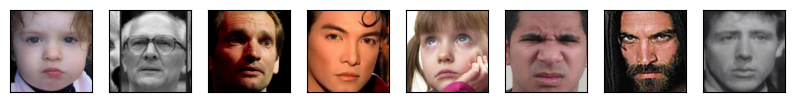

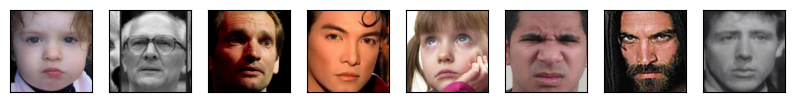

In [ ]:
no_norm = A.Compose([
    ToTensorV2(),                                # Convert the image to pytorch tensor
])
show_transformation(no_norm, epochs = 2, batch_size=batch_size)

It can be seen how all images in these two epochs are exactly the same ones. In some cases, the transformations done will be probabilistic (changing the images across epochs) or deterministic. The analysis will focusing on ``Normalization``. 

## 3.1. Normalization

It is tipically used in the context of computer vision but is more a standarization step than a data augmentation one, but it is trivial in the project. It is advisable to normalize image pixel values relative to the dataset mean and standard deviation for each channel. This helps converge faster, get consistent results when applying a model to new unseen information and can also it is useful for transfer learning. The values tipically used are the ones obtained from ImageNet:
$$mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]$$

Nervertheless, the values for the AffectNet dataset are computed to see if they differ. They are precomputed using the python program `AffectNet_normalization_values.py`. These are the results: 

In [ ]:
normalization_values = torch.load(
    os.path.join (PROCESSED_AFFECTNET_DIR, 'dataset_normalization_values.pt'))
mean = normalization_values['mean'].numpy()
std = normalization_values['std'].numpy()

# Print results
print(f"Mean = [", end ="")
print(f"{mean[0]:.3f}", f"{mean[1]:.3f}", f"{mean[2]:.3f}]", sep =", ", end = "")
print(f", std = [", end ="")
print(f"{std[0]:.3f}", f"{std[1]:.3f}", f"{std[2]:.3f}]", sep =", ")

Mean = [0.569, 0.446, 0.391], std = [0.275, 0.245, 0.238]


To compare both values, the follwing working schema will be applied. First an image batch will be shown having at first no normalization and then the one being analyzed. Then the mean and std values with the transformation will be computed for the test split. The objective is to choose the one that gives a result a mean value around 0 and standard deviation 1 for all color channels (it is expected that AffectNet values will be closer than ImageNet ones):

In [ ]:
normalization_ImageNet = A.Compose([
    A.Normalize(mean=[0.485, 0.456, 0.406],     # Convert from [0-255] to [0,1] interval and normalize by mean and std values 
                std=[0.229, 0.224, 0.225]),
    ToTensorV2()                                # Convert the image to pytorch tensor
])

normalization_AffectNet = A.Compose([           # Convert from [0-255] to [0,1] interval and normalize by mean and std values
    A.Normalize(mean=mean, std=std),            
    ToTensorV2()                                # Convert the image to pytorch tensor
])

To start, the general normalization will be used, that is to say, using the ImageNet values: 

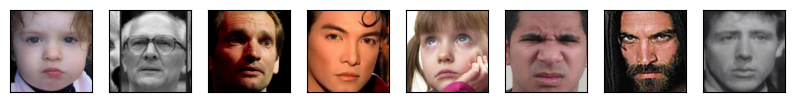

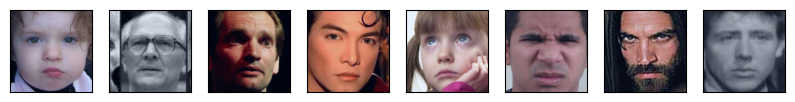

In [ ]:
show_transformation(no_norm, epochs = 1, batch_size=batch_size)
show_transformation(normalization_ImageNet, epochs = 1, batch_size = batch_size, adjust_to_vis_range = True)

**Note**: As normalizing by these values lead to image's pixel values outside [0-1] interval (visual range). To avoid having issues visualizing them, the result is compressed again to [0-1] range. To do that the following formula is applied: $$img' = \frac{img - min(img)}{max(img) - min(img)}$$

If this is not specified to do the following operation, the result will be clipped and the following note will be printed: "Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers)."

All images look similar to the original ones, but a bit whiter. The effect is not as visual as the normalization is helping the model to converge faster and get consistent results. Nevertherless, now the same transformation is applied but for the ImageNet dataset to see if the effect is similar. Now a torchvision transform is applied, as the ImageNet dataset class does not accept albumentation transforms. 

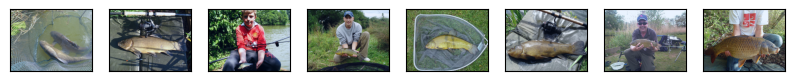

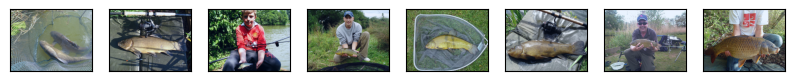

In [ ]:
normalization_ImageNet_for_test = transforms.Compose([
    transforms.ToTensor(),                              # Convert the image to pytorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],    # Normalize by mean and std values
                         std=[0.229, 0.224, 0.225])
])
show_transformation_Imagenet(normalization_ImageNet_for_test, batch_size = 8, adjust_to_vis_range = True)

The result is similar as before. Now the mean and standard deviation of the pixel values for the test split are computed using ImageNet normalization:

In [ ]:
# Create the datasets
dataset_test = AffectNetDatasetValidation(PROCESSED_AFFECTNET_DIR, "test", img_transforms=normalization_ImageNet)
# Create the dataloaders
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False) # No need to shuffle as we are showing the same images
# Compute results
compute_mean_std(dataloader_test)

100%|██████████| 125/125 [00:04<00:00, 28.29it/s]


{'mean': tensor([ 0.3186, -0.0829, -0.0947]),
 'std': tensor([1.2094, 1.1023, 1.0700])}

It can be observed how there is a good performing around blue and green channels but not in the red channel. This is due to the fact that the image dataset pixel value distribution is different from the ImageNet. Now the same experiment will be repeated with the values computed from the AffectNet dataset:

**Note**: The values computed with AffectNet are done using the `default` flag, this means that the ``train`` and ``validation`` splits are used to compute the mean and std values. The test split is not used for this purpose as it is used to evaluate the model.

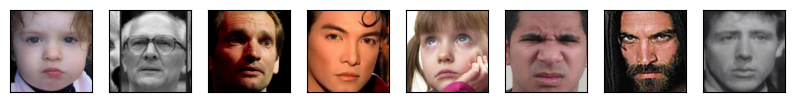

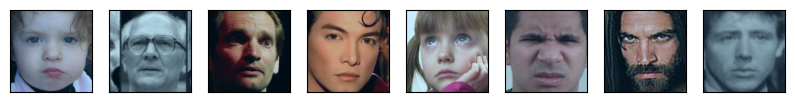

In [ ]:
show_transformation(no_norm, epochs = 1, batch_size=batch_size)
show_transformation(normalization_AffectNet, epochs = 1, batch_size = batch_size, adjust_to_vis_range = True)

It can be observed that now images have a whiter result (with less warmer colors) if we compare it with the result of ImageNet. One thing to note is that black and white images by nature will be set with blueish tones. So at first glance the mean and std values computed from the AffectNet dataset are better. It will be confirmed using by computing the mean and std values for the test split.

As the test set is not used to compute the mean and std values, it is a good way to check if the normalization is well done and the distribution of data is similar for test split. 

In [ ]:
# Create the datasets
dataset_test = AffectNetDatasetValidation(path = PROCESSED_AFFECTNET_DIR, datasplit = "test", img_transforms=normalization_AffectNet)
# Create the dataloaders
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False) # No need to shuffle as we are showing the same images
# Compute results
compute_mean_std(dataloader_test)

100%|██████████| 125/125 [00:04<00:00, 27.85it/s]


{'mean': tensor([-0.0418, -0.0352, -0.0271]),
 'std': tensor([1.0087, 1.0095, 1.0105])}

The results are much better, almost all channels are around 0 in mean and 1 std. So we will use the mean and std values computed from the AffectNet dataset for training and validating the model (unless some pretraining is applied). This will be included as the last transformation of the concatenation of transformation, as that is more a standarization step than a data augmentation step.


Now the analysis will proceed with ``ShiftScaleRotate`` transformation:

## 3.2. Shift Scale Rotate
ShiftScaleRotate transformation is a combination of rotation, translation and scale. It is a good way to augment the data and make the model more robust. I will use the following parameters:

In [ ]:
ShiftScaleRotate = A.Compose([
    A.ShiftScaleRotate(rotate_limit=(-15, 15), shift_limit=(0, 0.1), scale_limit=(-0.1, 0.1), 
    border_mode = cv2.BORDER_CONSTANT, value = 0.0, p = 0.5),
    ToTensorV2()
])

And this is the result:

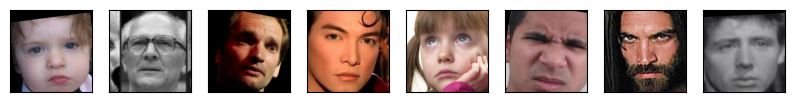

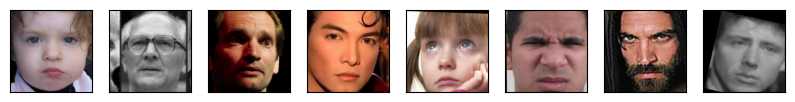

In [ ]:
show_transformation(ShiftScaleRotate, batch_size = batch_size)

It can be observed that the images are rotated, translated and scaled. This is a good way to augment the data on the fly, as the model will have to learn that the head has many possible orientations and learn from the same image different characteristics. Now each transformation will be applied separately to see how they work, starting with the rotation transformation (to test it the p value is set to 1.0, this way the transformation is always applied):

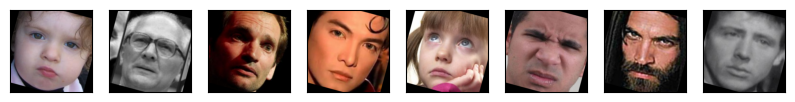

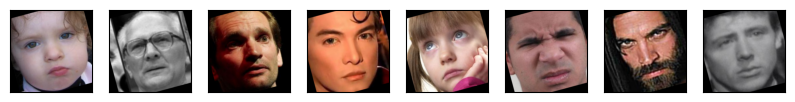

In [ ]:
ShiftScaleRotate = A.Compose([
    A.ShiftScaleRotate(rotate_limit=(-15, -15), shift_limit=0, scale_limit=0, border_mode = cv2.BORDER_CONSTANT, value = 0.0, p = 1.0),
    ToTensorV2()
])
show_transformation(ShiftScaleRotate, epochs = 1, batch_size = batch_size)
ShiftScaleRotate = A.Compose([
    A.ShiftScaleRotate(rotate_limit=(15, 15), shift_limit=0, scale_limit=0, border_mode = cv2.BORDER_CONSTANT, value = 0.0, p = 1.0),
    ToTensorV2()
])
show_transformation(ShiftScaleRotate, epochs = 1, batch_size = batch_size)

Now translate, first with limiting in (-0.1, -0.1), then (0.1, 0.1) and finally (-0.1, 0.1) to allow to see the different behaviours. 

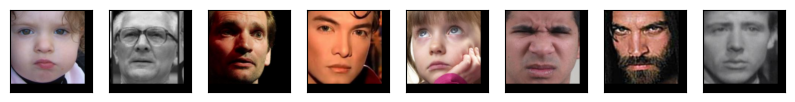

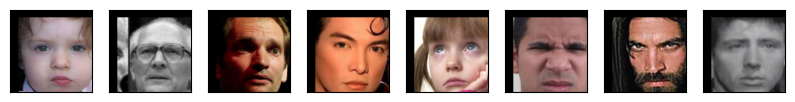

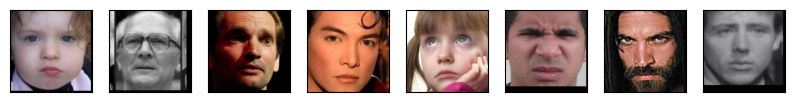

In [ ]:
ShiftScaleRotate = A.Compose([
    A.ShiftScaleRotate(rotate_limit=0, shift_limit=(-0.1, -0.1), scale_limit=0, border_mode = cv2.BORDER_CONSTANT, value = 0.0, p = 1.0),
    ToTensorV2()
])
show_transformation(ShiftScaleRotate, epochs = 1, batch_size = batch_size)
ShiftScaleRotate = A.Compose([
    A.ShiftScaleRotate(rotate_limit=0, shift_limit=(0.1, 0.1), scale_limit=0, border_mode = cv2.BORDER_CONSTANT, value = 0.0, p = 1.0),
    ToTensorV2()
])
show_transformation(ShiftScaleRotate, epochs = 1, batch_size = batch_size)
ShiftScaleRotate = A.Compose([
    A.ShiftScaleRotate(rotate_limit=0, shift_limit=(-0.1, 0.1), scale_limit=0, border_mode = cv2.BORDER_CONSTANT, value = 0.0, p = 1.0),
    ToTensorV2()
])
show_transformation(ShiftScaleRotate, epochs = 1, batch_size = batch_size)

The translation is done from center to 0.1 (normalized to image size) in any direction. The analysis continues with image scaling, starting with 0 scale, then -0.1 and then 0.1:

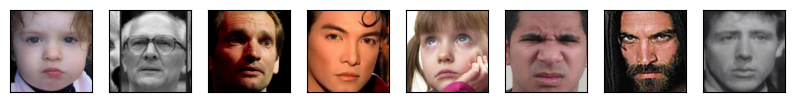

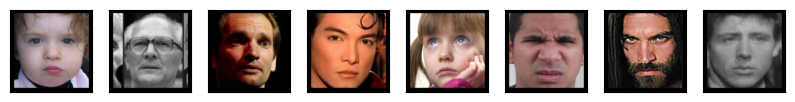

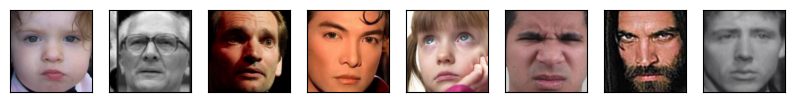

In [ ]:
ShiftScaleRotate = A.Compose([
    A.ShiftScaleRotate(rotate_limit=0, shift_limit=0, scale_limit=0, border_mode = cv2.BORDER_CONSTANT, value = 0.0, p = 1.0),
    ToTensorV2()
])
show_transformation(ShiftScaleRotate, epochs = 1, batch_size = batch_size)
ShiftScaleRotate = A.Compose([
    A.ShiftScaleRotate(rotate_limit=0, shift_limit=0, scale_limit=(-0.1, -0.1), border_mode = cv2.BORDER_CONSTANT, value = 0.0, p = 1.0),
    ToTensorV2()
])
show_transformation(ShiftScaleRotate, epochs = 1, batch_size = batch_size)
ShiftScaleRotate = A.Compose([
    A.ShiftScaleRotate(rotate_limit=0, shift_limit=0, scale_limit=(0.1, 0.1), border_mode = cv2.BORDER_CONSTANT, value = 0.0, p = 1.0),
    ToTensorV2()
])
show_transformation(ShiftScaleRotate, epochs = 1, batch_size = batch_size)

After testing all parameters, the analysis continues with ``Horizontal Flip`` transformation:

## 3.3. Horizontal Flip
This is useful to get invariance around the mirror effect, as some cameras apply the correction and some not. Also it helps the model to be more robust, as in general faces are simetric around the vertical axis. The vertical flip won't be applied, as it is not usual to see inverted faces. I will use the following parameters:


In [ ]:
HorizontalFlip = A.Compose([
    A.HorizontalFlip(p = 0.5),
    ToTensorV2()
])

So the result is the following:

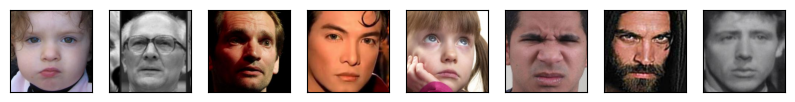

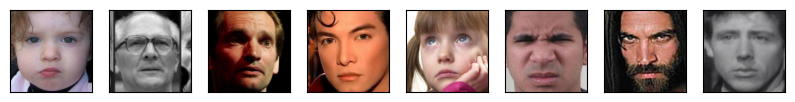

In [ ]:
show_transformation(HorizontalFlip, batch_size=batch_size)

With probability `p = 0.5`, the images are inverted, leading to an augmentation to the data. The next transformation to test is ``Color Jitter``:

## 3.4. ColorJitter
This transformation is used to change the brightness, contrast, saturation and hue of the image. It is useful to make the model more robust and to get invariance to these changes in light conditions (common in a car cabin environment) I will use the following parameters:

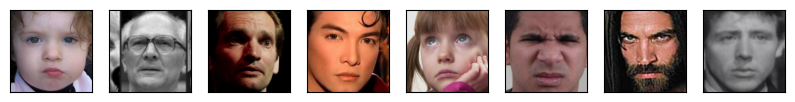

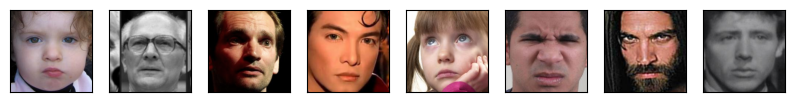

In [ ]:
ColorJitter = A.Compose([
    A.ColorJitter(brightness=[0.85, 1.15], contrast=[0.9,1.1], saturation=[0.75,1.1], hue=[-0.01,0.02],
    p = 0.5),
    ToTensorV2()
])
show_transformation(ColorJitter, batch_size=batch_size)

It can be observed that there are many changes across the epochs. This is a good way to augment the data, as the model will have to learn from the same image different characteristics. When training the most suitable transformation will be analyzed and chosen. Now the transformations will be deterministic. Starting with brightness, the range of values is from 0.5 to 1.5. in 0.25 steps:

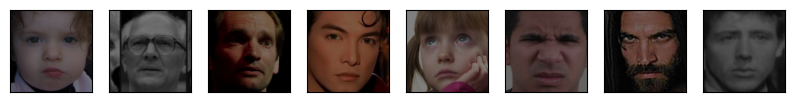

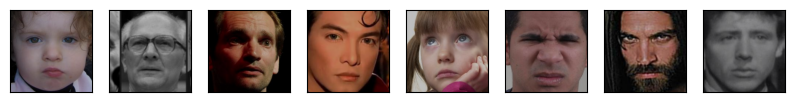

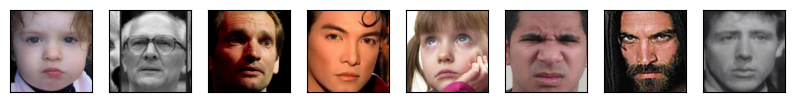

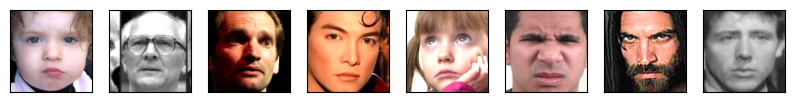

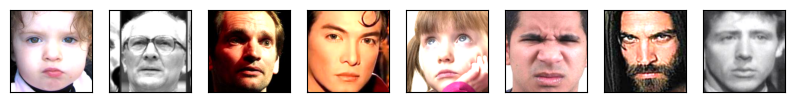

In [ ]:
ColorJitterbright = A.Compose([
    A.ColorJitter(brightness=[0.5,0.5], contrast=0, saturation=0, hue=0,
    p = 1.0),
    ToTensorV2()
])
show_transformation(ColorJitterbright, epochs = 1, batch_size=batch_size)
ColorJitterbright = A.Compose([
    A.ColorJitter(brightness=[0.75,0.75], contrast=0, saturation=0, hue=0,
    p = 1.0),
    ToTensorV2()
])
show_transformation(ColorJitterbright, epochs = 1, batch_size=batch_size)
ColorJitterbright = A.Compose([
    A.ColorJitter(brightness=[1,1], contrast=0, saturation=0, hue=0,
    p = 1.0),
    ToTensorV2()
])
show_transformation(ColorJitterbright, epochs = 1, batch_size=batch_size)
ColorJitterbright = A.Compose([
    A.ColorJitter(brightness=[1.25,1.25], contrast=0, saturation=0, hue=0,
    p = 1.0),
    ToTensorV2()
])
show_transformation(ColorJitterbright, epochs = 1, batch_size=batch_size)
ColorJitterbright = A.Compose([
    A.ColorJitter(brightness=[1.5,1.5], contrast=0, saturation=0, hue=0,
    p = 1.0),
    ToTensorV2()
])
show_transformation(ColorJitterbright, epochs = 1, batch_size=batch_size)

The second will be contrast, with a similar approach:

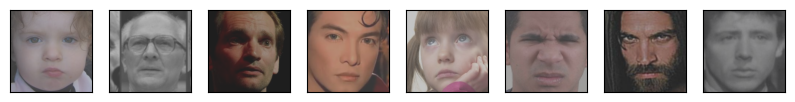

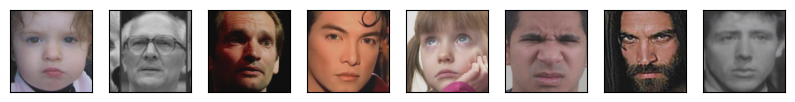

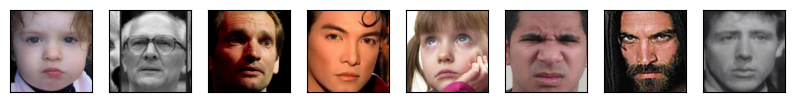

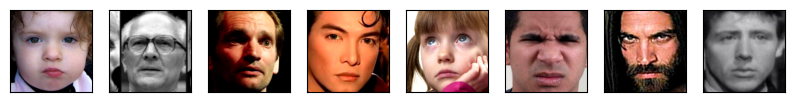

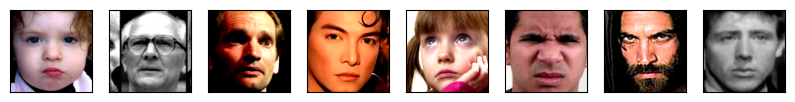

In [ ]:
ColorJittercontrast = A.Compose([
    A.ColorJitter(brightness=0, contrast=[0.5,0.5], saturation=0, hue=0,
    p = 1.0),
    ToTensorV2()
])
show_transformation(ColorJittercontrast, epochs = 1, batch_size=batch_size)
ColorJittercontrast = A.Compose([
    A.ColorJitter(brightness=0, contrast=[0.75,0.75], saturation=0, hue=0,
    p = 1.0),
    ToTensorV2()
])
show_transformation(ColorJittercontrast, epochs = 1, batch_size=batch_size)
ColorJittercontrast = A.Compose([
    A.ColorJitter(brightness=0, contrast=[1,1], saturation=0, hue=0,
    p = 1.0),
    ToTensorV2()
])
show_transformation(ColorJittercontrast, epochs = 1, batch_size=batch_size)
ColorJittercontrast = A.Compose([
    A.ColorJitter(brightness=0, contrast=[1.25,1.25], saturation=0, hue=0,
    p = 1.0),
    ToTensorV2()
])
show_transformation(ColorJittercontrast, epochs = 1, batch_size=batch_size)
ColorJittercontrast = A.Compose([
    A.ColorJitter(brightness=0, contrast=[1.5,1.5], saturation=0, hue=0,
    p = 1.0),
    ToTensorV2()
])
show_transformation(ColorJittercontrast, epochs = 1, batch_size=batch_size)

Now with saturation, with a similar approach:

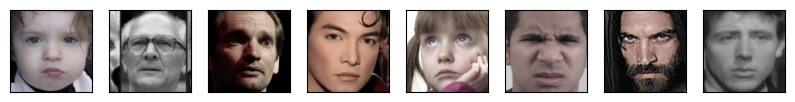

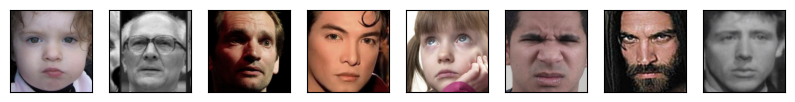

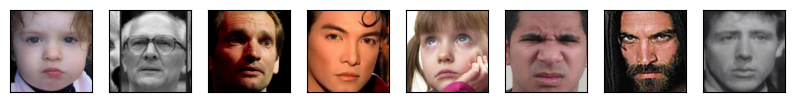

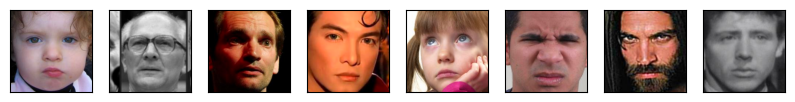

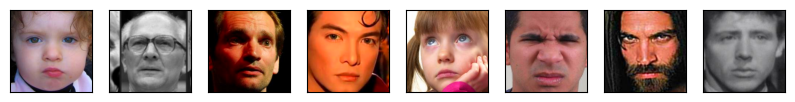

In [ ]:
ColorJittersaturation = A.Compose([
    A.ColorJitter(brightness = 0, contrast = 0, saturation = [0.5,0.5], hue = 0,
    p = 1.0),
    ToTensorV2()
])
show_transformation(ColorJittersaturation, epochs = 1, batch_size=batch_size)
ColorJittersaturation = A.Compose([
    A.ColorJitter(brightness = 0, contrast = 0, saturation = [0.75,0.75], hue = 0,
    p = 1.0),
    ToTensorV2()
])
show_transformation(ColorJittersaturation, epochs = 1, batch_size=batch_size)
ColorJittersaturation = A.Compose([
    A.ColorJitter(brightness = 0, contrast = 0, saturation=[1,1], hue = 0,
    p = 1.0),
    ToTensorV2()
])
show_transformation(ColorJittersaturation, epochs = 1, batch_size=batch_size)
ColorJittersaturation = A.Compose([
    A.ColorJitter(brightness = 0, contrast = 0, saturation=[1.25,1.25], hue = 0,
    p = 1.0),
    ToTensorV2()
])
show_transformation(ColorJittersaturation, epochs = 1, batch_size=batch_size)
ColorJittersaturation = A.Compose([
    A.ColorJitter(brightness = 0, contrast = 0, saturation = [1.5,1.5], hue = 0,
    p = 1.0),
    ToTensorV2()
])
show_transformation(ColorJittersaturation, epochs = 1, batch_size=batch_size)

Finally, with hue, with a similar approach but with an smaller interval of values that is: [-0.05, 0.05]. Concretly: [-0.05, -0.025, -0.01, 0, 0.01, 0.025, 0.05].

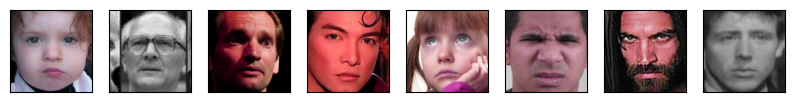

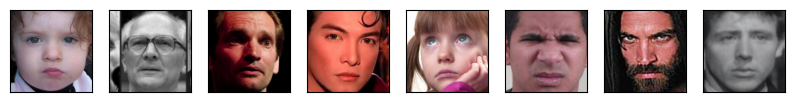

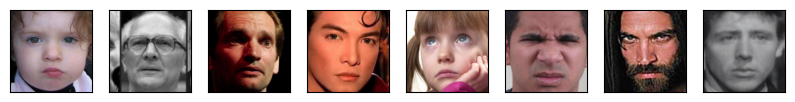

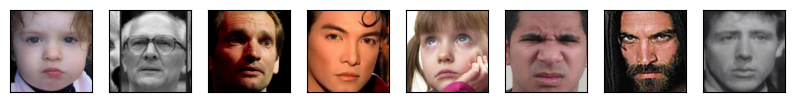

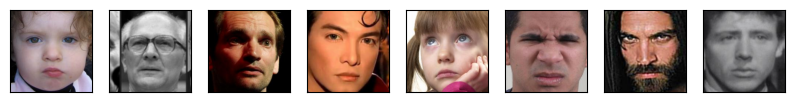

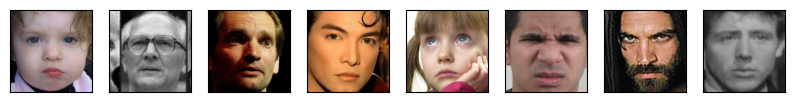

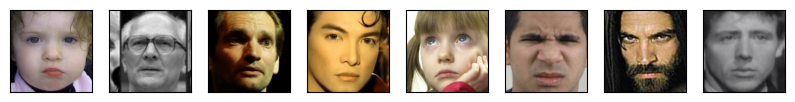

In [ ]:
ColorJitterhue = A.Compose([
    A.ColorJitter(brightness = 0, contrast = 0, saturation = 0, hue = [-0.05,-0.05],
    p = 1.0),
    ToTensorV2()
])
show_transformation(ColorJitterhue, epochs = 1, batch_size=batch_size)
ColorJitterhue = A.Compose([
    A.ColorJitter(brightness = 0, contrast = 0, saturation = 0, hue = [-0.025,-0.025],
    p = 1.0),
    ToTensorV2()
])
show_transformation(ColorJitterhue, epochs = 1, batch_size=batch_size)
ColorJitterhue = A.Compose([
    A.ColorJitter(brightness = 0, contrast = 0, saturation = 0, hue = [-0.01,-0.01],
    p = 1.0),
    ToTensorV2()
])
show_transformation(ColorJitterhue, epochs = 1, batch_size=batch_size)
ColorJitterhue = A.Compose([
    A.ColorJitter(brightness = 0, contrast = 0, saturation = 0, hue = [0,0],
    p = 1.0),
    ToTensorV2()
])
show_transformation(ColorJitterhue, epochs = 1, batch_size=batch_size)
ColorJitterhue = A.Compose([
    A.ColorJitter(brightness = 0, contrast = 0, saturation = 0, hue=[0.01,0.01],
    p = 1.0),
    ToTensorV2()
])
show_transformation(ColorJitterhue, epochs = 1, batch_size=batch_size)
ColorJitterhue = A.Compose([
    A.ColorJitter(brightness = 0, contrast = 0, saturation = 0, hue=[0.025,0.025],
    p = 1.0),
    ToTensorV2()
])
show_transformation(ColorJitterhue, epochs = 1, batch_size=batch_size)
ColorJitterhue = A.Compose([
    A.ColorJitter(brightness = 0, contrast = 0, saturation = 0, hue=[0.05,0.05],
    p = 1.0),
    ToTensorV2()
])
show_transformation(ColorJitterhue, epochs = 1, batch_size=batch_size)

As the last transformation, the analysis will proceed with ``Gaussian/ISO Noise`` transformation:

## 3.5. Gaussian Noise
The Gaussian noise is a type of noise that has a probability density function equal to that of the normal distribution. It is used to add a random noise to the image. This makes the model more consistent but at a cost that can make the model underperform.

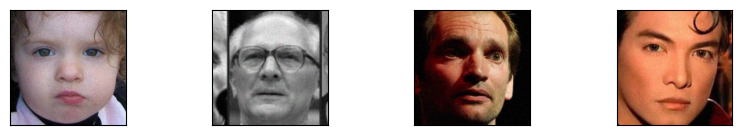

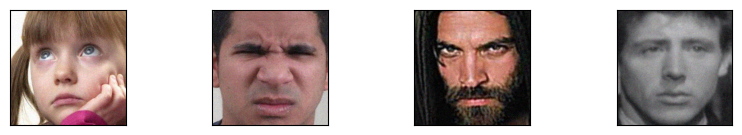

In [ ]:
GaussianNoise = A.Compose([
    A.GaussNoise(var_limit=(75.0, 75.0), p = 1.0),
    ToTensorV2()
])
show_transformation(GaussianNoise, epochs = 1, batch_size=4)

It can be observed that the images are noisier. This is a good way to augment the data, as the model will have to learn from the image the same characteristics. Now the analysis will proceed with ``Random Shadow`` transformation:

## 3.7. Random Shadow
The random shadow transformation is used to add a shadow to the image. It is useful to make the model more robust to this kind of noise (for example a shadow in the face).

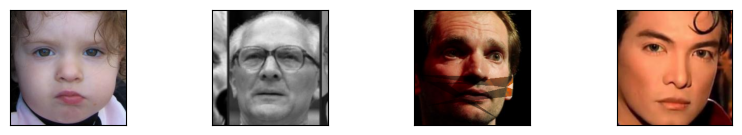

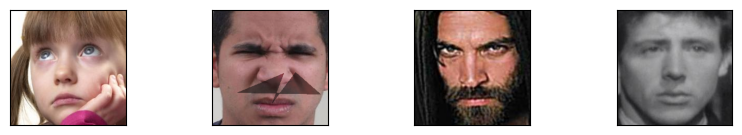

In [ ]:
RandomShadow = A.Compose([
    A.RandomShadow (p=0.5),
    ToTensorV2()
])
show_transformation(RandomShadow, epochs = 1, batch_size=4)

The result is not very natural, so to avoid making the model to underperform it will be discarded. Now the analysis will focus on ``Coarse Dropout`` transformation:

## 3.7. Coarse Dropout
Coarse dropout is a transformation that randomly selects a rectangle region in an image and erases its pixels with random values. It is useful to make the model more robust to occlusions and to get invariance to this kind of noise. I will use the following parameters:

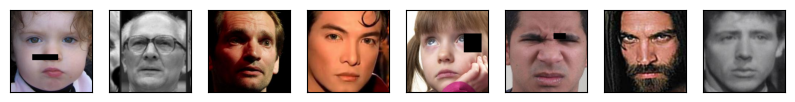

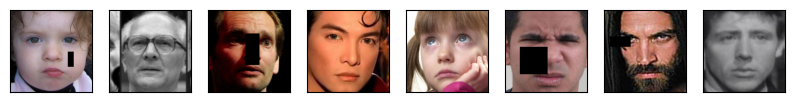

In [ ]:
CoarseDropout = A.Compose([
    A.CoarseDropout(max_height=85, min_height = 16, max_width = 85, min_width = 16,  
        fill_value = 0.0, max_holes = 1, min_holes = 1, p = 0.5),
    ToTensorV2()
])
show_transformation(CoarseDropout, batch_size=batch_size)

Now the results will be shown with max and min values:

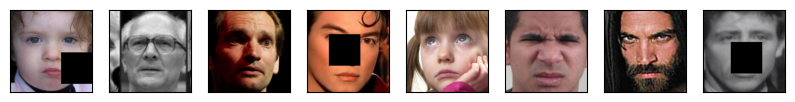

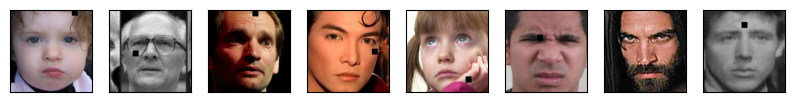

In [ ]:
CoarseDropout = A.Compose([
    A.CoarseDropout(max_height=85, min_height = 85, max_width = 85, min_width = 85,  
        fill_value = 0.0, max_holes = 1, min_holes = 1, p = 0.5),
    ToTensorV2()
])
show_transformation(CoarseDropout, epochs = 1, batch_size=batch_size)
CoarseDropout = A.Compose([
    A.CoarseDropout(max_height=16, min_height = 16, max_width = 16, min_width = 16,  
        fill_value = 0.0, max_holes = 1, min_holes = 1, p = 1),
    ToTensorV2()
])
show_transformation(CoarseDropout, epochs = 1, batch_size=batch_size)

It can be seen how it occludes some part of the face. This is a good way to augment the data, as the model will have to learn from the same image different characteristics. But maybe these changes are too aggresive and may lead the model to underperform. During training, the most suitable transformation will be analyzed. Finally, the analysis on data transformation and augmentation will be concluded.

## 3.8. Conclusions

Now I can sum up all the transformations and see how they work together. The order of image transformations can indeed have an impact on the final result. However, the best order often depends on the specific task and data. The transformations are applied in the following order:

1. Horizontal flip
2. Shift, scale, rotate
3. Coarse dropout
4. Color jitter
5. Gauss noise
6. Normalization

- **Horizontal flip, shift, scale, rotate**: These transformations are geometric in nature. They change the position and orientation of objects in the image, but not their appearance. It's often a good idea to apply these transformations first, because they can create variation in the data without changing the inherent properties of the objects in the image.

- **Coarse dropout**: This transformation randomly removes parts of the image, which can help the model learn to recognize objects even when parts of them are missing. It's often applied after geometric transformations to ensure that the dropout is applied to the transformed images.

- **Color jitter, Gauss noise**: These transformations change the appearance of the objects in the image, but not their position or orientation. They're often applied after geometric transformations and dropout, because they can create additional variation in the data without changing the inherent properties of the objects in the image.

- **Normalization**: This transformation is used to normalize the pixel values of the image. It is a standarization step that is applied to the image after all the transformations are done. It is important to note that the mean and standard deviation are computed for each channel separately. It is used to help the model converge faster and get consistent results when applying a model to new unseen information.

The best order can depend on the specific task and data, so it might be worth experimenting with different orders to see what works best for the context of the project. Now, some epochs will be shown, bit first with no normalization.

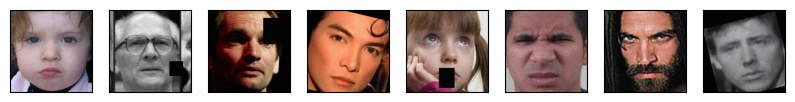

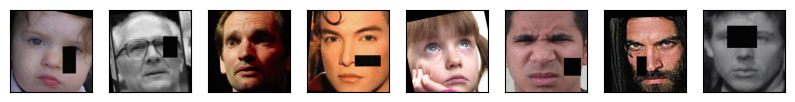

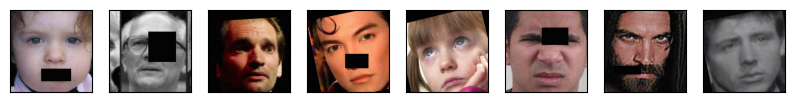

In [ ]:
all_transformations_no_norm = A.Compose([
    A.HorizontalFlip(p = 0.5),
    A.ShiftScaleRotate(rotate_limit=(-15, 15), shift_limit=(0, 0.1), scale_limit=(-0.1, 0.1), 
    border_mode = cv2.BORDER_CONSTANT, value = 0.0, p = 0.5),
    A.CoarseDropout(max_height=85, min_height = 16, max_width = 85, min_width = 16,  
        fill_value = 0.0, max_holes = 1, min_holes = 1, p = 0.5),
    A.ColorJitter(brightness=[0.85, 1.15], contrast=[0.9,1.1], saturation=[0.75,1.1], hue=[-0.01,0.02],
    p = 0.5),
    A.GaussNoise(var_limit=(75.0, 75.0), p = 1.0),
    A.Normalize(mean=[0,0,0], std = [1,1,1]),
    ToTensorV2()])
show_transformation(all_transformations_no_norm, epochs = 3, batch_size = batch_size)

In [ ]:
# Create the datasets
dataset_test = AffectNetDatasetValidation(PROCESSED_AFFECTNET_DIR, "test", img_transforms=all_transformations_no_norm)
# Create the dataloaders
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False) # No need to shuffle as we are showing the same images
# Compute results
compute_mean_std(dataloader_test)

100%|██████████| 125/125 [00:33<00:00,  3.69it/s]


{'mean': tensor([0.5102, 0.4036, 0.3553]),
 'std': tensor([0.3021, 0.2640, 0.2518])}

The mean and std values are different from what we have seen, this is expected, as the color distribution changes with the transformations. Now the experiment is repeated with normalization, it is applied the same normalization to [0-1] range in order to visualizate it properly: 

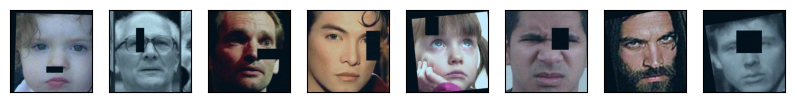

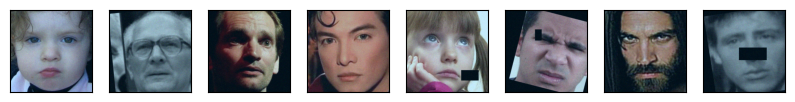

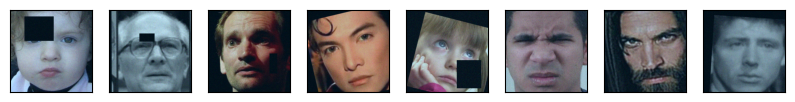

In [ ]:
all_transformations = A.Compose([
    A.HorizontalFlip(p = 0.5),
    A.ShiftScaleRotate(rotate_limit=(-15, 15), shift_limit=(0, 0.1), scale_limit=(-0.1, 0.1), 
    border_mode = cv2.BORDER_CONSTANT, value = 0.0, p = 0.5),
    A.CoarseDropout(max_height=85, min_height = 16, max_width = 85, min_width = 16,  
        fill_value = 0.0, max_holes = 1, min_holes = 1, p = 0.5),
    A.ColorJitter(brightness=[0.85, 1.15], contrast=[0.9,1.1], saturation=[0.75,1.1], hue=[-0.01,0.02],
    p = 0.5),
    A.GaussNoise(var_limit=(75.0, 75.0), p = 1.0),
    A.Normalize(mean=mean, std=std),
    ToTensorV2()])
show_transformation(all_transformations, epochs = 3, batch_size=batch_size, adjust_to_vis_range = True)

In [ ]:
# Create the datasets
dataset_test = AffectNetDatasetValidation(PROCESSED_AFFECTNET_DIR, "test", img_transforms=all_transformations)
# Create the dataloaders
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False) # No need to shuffle as we are showing the same images
# Compute results
compute_mean_std(dataloader_test)

  0%|          | 0/125 [00:00<?, ?it/s]

100%|██████████| 125/125 [00:34<00:00,  3.65it/s]


{'mean': tensor([-0.2123, -0.1723, -0.1499]),
 'std': tensor([1.1015, 1.0794, 1.0569])}

There is an improvement in the mean and std values, but it is a bit worse (mostly for the mean) compared no transformation. This is the expected result as the transformation lead to changes in color distribution. When training, the transformation selection will be done. The analysis is concluded.

# 4. Conclusions

The data validation analysis showed the following findings:
- The data preprocessing is correctly applied and has the expected format and values. 
- The weighted random sampler is effective in addressing the data imbalance issue, as it provides a more uniform distribution of emotions in each batch. But this also causes some oversampling on some emotions, so it is necessary to apply good augmentation techniques to avoid overfitting.
- The model training process using this sampler is expected to be at minimum of 9 epochs, as this will let the model to see 95% of the dataset.
- The image normalization and transformations is performed on-the-fly, this way it is done a data augmentation different on each time the model sees the same image. These transformations involve horizontal flip, shift, scale, rotate, coarse dropout, color jitter, gauss noise and normalization. During training the most suitable transformations will be analyzed per each model.


Based on these findings, it can be concluded that the report successfully performs data validation and analysis on the AffectNet dataset. Further analysis and experimentation will be conducted during training to improve the model's performance and explore additional insights from the dataset.

# References
* A. Mollahosseini; B. Hasani; M. H. Mahoor, "AffectNet: A Database for Facial Expression, Valence, and Arousal Computing in the Wild," in IEEE Transactions on Affective Computing,  2017. [AffectNet paper](https://arxiv.org/pdf/1708.03985.pdf)